# Build classifier datasets

Builds a three-column dataframes:
 - term: term from either the DEFT dataset or MEsh terminology or Other Terminology or local annotation
 - label: Mesh code C**
 - term source: "DEFT-train", "DEFT-val", "Mesh-FR", "Mesh-EN", "local"

In [22]:
from os.path import isfile, isdir, join
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections
import math

IN_BRAT_DIR = '/export/home/cse200093/brat_data/Expe_PHENO_2'
IN_CLASSIFIER_FILE = './resources/03122021_classifier_local_train.csv'

# IN_FR_MESH_FILE = './resources/28062021_ALL_MESH_FR.csv'

OUT_DF = './resources/25012022_classifier_local_train_val.csv'

local_train_DF = './resources/Train_local_annotated_without_neg_par_hyp.csv'

local_DF = './resources/25012022_train_val_local_annotated_without_neg_par_hyp.csv'

assert isdir(IN_BRAT_DIR)
assert isfile(IN_CLASSIFIER_FILE)
assert isfile(local_train_DF)

In [23]:
term_df = pd.read_csv(IN_CLASSIFIER_FILE)
train_df = pd.read_csv(local_train_DF)
labels = set(term_df['label'].unique())
    
labels

{'ORL',
 'blessures',
 'cardiovasculaires',
 'chimiques',
 'digestif',
 'endocriniennes',
 'etatsosy',
 'femme',
 'genetique',
 'hemopathies',
 'homme',
 'immunitaire',
 'infections',
 'nerveux',
 'nutritionnelles',
 'oeil',
 'osteomusculaires',
 'parasitaires',
 'peau',
 'respiratoire',
 'stomatognathique',
 'tumeur',
 'virales'}

In [24]:
def find_offsets_relaxed_match(label_infos, left_offset, right_offset):
    matches = []
    for o in label_infos.keys():
        o_list = o.split(' ')
        leftmost_offset = int(o_list[0])
        rightmost_offset = int(o_list[-1])
        if leftmost_offset <= left_offset <= rightmost_offset or leftmost_offset <= right_offset <= rightmost_offset or left_offset <= leftmost_offset <= right_offset or left_offset <= rightmost_offset <= right_offset:
            matches.append((o, label_infos[o]))
    return matches

In [25]:
import os 
files = os.listdir(IN_BRAT_DIR)
ann_files = [ann_file for ann_file in files if ann_file.endswith(".ann")]

ENTITY_REGEX = re.compile('^(T\d+)\t([^ ]+) ([^\t]+)\t(.*)$')

tags = []
data = []

for ann_file in ann_files: 
    ann_path = join(IN_BRAT_DIR, ann_file) 
    assert isfile(ann_path)
    source = ann_file
    # Read ann file
    with open(ann_path, 'r', encoding='utf-8') as f_in:
        lines = f_in.readlines()
            
    columns = ['term', 'label', 'source']


            
#for source, source_infos in deft_dfs.items():
#    files = source_infos[1]
#    for ann_file in files:
        #if '-24-' not in ann_file:
        #    continue
#        ann_path = join(IN_BRAT_DIR, ann_file)
#        assert isfile(ann_path)
        # Read ann file
#        with open(ann_path, 'r', encoding='utf-8') as f_in:
#            lines = f_in.readlines()

        # Read corresponding txt file
    #    txt_path = join(IN_BRAT_DIR, ann_file[:-4] + ".txt")
    #    assert isfile(txt_path)
    #    text = open(txt_path, 'r', encoding='utf-8').read()
    

    # First pass -> extract all labels (i.e entity with Mesh-like tags)
    label_infos = {}
    other_infos = {}
    for line in lines:
        entity_match = ENTITY_REGEX.match(line.strip())
        if entity_match is not None:
            ann_id = entity_match.group(1)
            label = entity_match.group(2)
            offsets = entity_match.group(3)
            span = entity_match.group(4)
            if label in labels:
                label_list = label_infos.get(offsets, [])
                label_list.append((ann_id, label, offsets, span))
                label_infos[offsets] = label_list
                data.append([span, label, source])

    # Find other mentions with the same offsets
    # restrict to pathology and sosy
    for line in lines:
            entity_match = ENTITY_REGEX.match(line.strip())
            if entity_match is not None:
                ann_id = entity_match.group(1)
                label = entity_match.group(2)
                offsets = entity_match.group(3)
                offset_list = offsets.split(' ')
                leftmost_offset = int(offset_list[0])
                rightmost_offset = int(offset_list[-1])
                span = entity_match.group(4)
                if label not in labels:
                    if label in ('pathologie', 'sosy'):
                        res = find_offsets_relaxed_match(label_infos, leftmost_offset, rightmost_offset)
                        if len(res):
                            for r in res:
                                new_offsets, mesh_tags = r
                                for i in mesh_tags:
                                    assert i[1] in labels
                                    data.append([span, i[1], source])
                                #tags.append([ann_file, ann_id, new_offsets, span, label, mesh_tags])
                        #else:                        
                        #    tags.append([ann_file, ann_id, offsets, span, label, None])

    #    for offsets in label_infos.keys():
    #        offset_df = [t for t in tags if t[2] == offsets]
    #        if not len(offset_df):
    #            offset_list = offsets.split(' ')
    #            leftmost_offset = int(offset_list[0])
    #            rightmost_offset = int(offset_list[-1])
    #            span = text[leftmost_offset:rightmost_offset]
    #            tags.append([ann_file, ann_id, offsets, span, 'null', ', '.join([i[1] for i in label_infos[offsets]])])
    #     
#tag_df = pd.DataFrame(data=tags, columns=['ann_file', 'ann_id', 'offsets', 'span', 'label', 'tag'])
len(data)

15391

In [26]:
data[0:10]

[['maladie de Takayasu', 'cardiovasculaires', 'CRH_taka_sample_51.ann'],
 ['Takayasu', 'cardiovasculaires', 'CRH_taka_sample_51.ann'],
 ['malaise', 'etatsosy', 'CRH_taka_sample_51.ann'],
 ["angor d'effort", 'cardiovasculaires', 'CRH_taka_sample_51.ann'],
 ['troponine augmentée', 'etatsosy', 'CRH_taka_sample_51.ann'],
 ['SCA ST-', 'cardiovasculaires', 'CRH_taka_sample_51.ann'],
 ['occlusion du tronc commun', 'cardiovasculaires', 'CRH_taka_sample_51.ann'],
 ['maladie de Takayasu', 'cardiovasculaires', 'CRH_taka_sample_51.ann'],
 ["sténose de l'artère pulmonaire",
  'cardiovasculaires',
  'CRH_taka_sample_51.ann'],
 ['micro IA', 'cardiovasculaires', 'CRH_taka_sample_51.ann']]

## Add French UMLS MeSH to create the term set

In [27]:
if 'Unnamed: 0' in term_df.columns:
    del(term_df['Unnamed: 0'])

if 'Unnamed: 0.1' in term_df.columns:
    del(term_df['Unnamed: 0.1'])
    
term_df.sample(5)

,term,label,source
743,hépato splénomégalie,etatsosy,DEFT-train
62576,hypermétabolisme pariétal aortique modéré mais...,cardiovasculaires,CRH_taka_sample_7.ann
23040,Rétrécissement de la valve mitrale,cardiovasculaires,CUI_syn_FR
10503,Hypoplasie segmentaire du nerf optique,oeil,CUI_syn_FR
4020,Aspergillose pulmonaire,respiratoire,Mesh-FR


In [28]:
if 'Unnamed: 0' in train_df.columns:
    del(train_df['Unnamed: 0'])

if 'Unnamed: 0.1' in train_df.columns:
    del(train_df['Unnamed: 0.1'])
    
train_df.sample(5)

,term,label,source
4510,OVCR,cardiovasculaires,CRH_taka_sample_35.ann
1620,TVP,cardiovasculaires,CRH_lupus_sample_19.ann
7880,sténose de l'artère pulmonaire,respiratoire,CRH_taka_sample_20.ann
2658,neuropathie sensitivo-motrice axonale chronique,nerveux,CRH_lupus_sample_33.ann
4693,hématomes diffus,etatsosy,CRH_sapl_sample_25.ann


In [29]:
dataset_df = pd.DataFrame(data=list(data), columns=columns)
dataset_df = dataset_df.drop_duplicates().reset_index(drop=True)
dataset_df.sample(15)

,term,label,source
2858,Majoration de la sténose de l'artère mésentéri...,cardiovasculaires,CRH_taka_sample_47.ann
5809,ulcération buccale,stomatognathique,CRH_sapl_sample_0.ann
1579,atteinte musculaire,etatsosy,CRH_scl_sample_46.ann
2569,Lombosciatique,osteomusculaires,CRH_taka_sample_35.ann
10161,surinfection,infections,CRH_scl_sample_42.ann
791,Amélioration rapide de la polyarthrite,etatsosy,CRH_lupus_sample_51.ann
11193,vascularite lupique,immunitaire,CRH_sapl_sample_28.ann
6478,atteinte pulmonaire : fibrose et condensations,respiratoire,CRH_scl_sample_47.ann
2987,Rhumatisme articulaire aigu,infections,CRH_sapl_sample_25.ann
514,Syndrome sec,etatsosy,CRH_scl_sample_10.ann


In [30]:
len(dataset_df)

13617

In [32]:
# save local dataset without negated, hypothetic of family terms
print('len dataset df',len(dataset_df))
dataset_df.to_csv(local_DF)

len dataset df 13617


In [45]:
# concatenate local train and val dataset and save
local_df = pd.concat([train_df, dataset_df])
print('len local df',len(local_df))
local_df.sample(20)

len local df 13125


,term,label,source
1347,Hypoventilationbilatéral et symétrique,etatsosy,CRH_taka_sample_27.ann
104,tachycardie irrégulière,cardiovasculaires,CRH_sapl_sample_51.ann
5975,anti-ADN natifs positifs,etatsosy,CRH_lupus_sample_31.ann
6567,Perturbations du BHC,etatsosy,CRH_scl_sample_24.ann
6200,sepsis à Staphylocoques à point de départ du PAC,infections,CRH_sapl_sample_21.ann
3434,légèrement améliorée,etatsosy,CRH_scl_sample_44.ann
5695,amélioration clinique,etatsosy,CRH_taka_sample_31.ann
693,éruption cutanée,peau,CRH_lupus_sample_52.ann
2592,Anévrisme de l'aorte thoracique,cardiovasculaires,CRH_taka_sample_46.ann
3628,hémiplégie,nerveux,CRH_taka_sample_0.ann


In [31]:
df_check = dataset_df.groupby('source')['label'].nunique()

# df_check.to_csv('test_sosy.csv')

len(df_check)

151

In [47]:
# Concatenate the 2 datasets :
dataset = pd.concat([term_df, dataset_df])
dataset.sample(20)

,term,label,source
41933,Accidents vasculaires cérébraux lacunaires,nerveux,CUI_syn_FR
59813,Cancer du Sein,tumeur,CRH_sapl_sample_20.ann
2397,Mycoses oculaires,infections,Mesh-FR
36482,Ectasie vasculaire antrale gastrique,cardiovasculaires,CUI_syn_FR
39825,Syndrome postphlébitique,cardiovasculaires,CUI_syn_FR
26063,Infection à Proteus SAI,infections,CUI_syn_FR
27222,Hypoascorbémie,nutritionnelles,CUI_syn_FR
32172,Albinisme partiel,nutritionnelles,CUI_syn_FR
15439,Néphropathie diabétique,endocriniennes,CUI_syn_FR
32575,MPS II,peau,CUI_syn_FR


In [48]:
len(dataset)
# save
dataset.to_csv(OUT_DF)

In [49]:
len(dataset)

71108

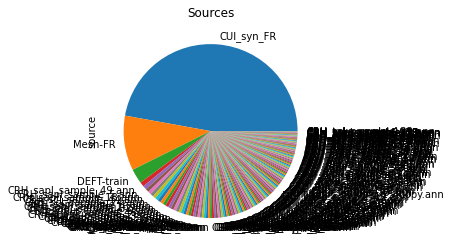

In [50]:
ax = dataset['source'].value_counts().plot(kind='pie',
                                    #figsize=(14,8),
                                              legend=False,
                                              title="Sources")

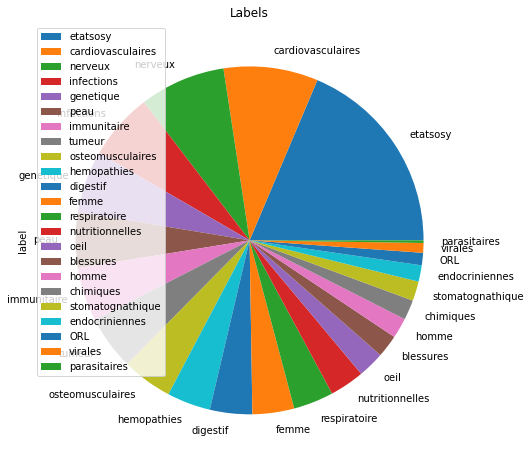

In [51]:
ax = dataset['label'].value_counts().plot(kind='pie',
                                             figsize=(14,8),
                                             legend = True,
                                             title="Labels")


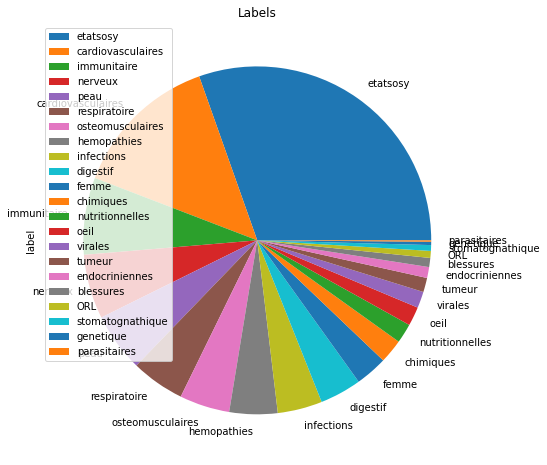

In [12]:
ax = dataset_df['label'].value_counts().plot(kind='pie',
                                             figsize=(14,8),
                                             legend = True,
                                             title="Labels")


In [11]:
dataset_df.sample(20)

dataset_df.to_csv(local_DF)

### OLD VERSION

### Add Mesh files

In [12]:
# mesh_df = pd.read_excel(IN_FR_MESH_FILE)
mesh_df = pd.read_csv(IN_FR_MESH_FILE)

In [7]:
#for i, raw in mesh_df.iterrows():
#    label = raw['Labels']
#    if type(label) != str and math.isnan(label):
#        continue
#    if type(label) == str and label == '':
#        continue
#    assert label in labels, f'{i} - {label}'
#    term = raw['Entité/term/expression régulière'].strip()
#    source = 'Mesh-FR'
#    data.append([term, label, source])

In [16]:
if 'Unnamed: 0' in mesh_df.columns:
    del(mesh_df['Unnamed: 0'])
if 'mesh_ui'in mesh_df.columns:
    del(mesh_df['mesh_ui'])
    
mesh_df['source'] = "full-MeSH-FR"

mesh_df

,term,label,source
0,Abdomen aigu,etatsosy,full-MeSH-FR
1,Abdomen chirurgical,etatsosy,full-MeSH-FR
2,Abdomen urgent,etatsosy,full-MeSH-FR
3,Traumatismes de l'abdomen,blessures,full-MeSH-FR
4,Blessures abdominales,blessures,full-MeSH-FR
...,...,...,...
21562,Remaniement vasculaire,etatsosy,full-MeSH-FR
21563,Remodelage de vaisseau,etatsosy,full-MeSH-FR
21564,Remodelage de vaisseaux,etatsosy,full-MeSH-FR
21565,Remodelage artériel pulmonaire,etatsosy,full-MeSH-FR


In [17]:
dataset_df = pd.DataFrame(data=list(data), columns=columns)
dataset_df = dataset_df.drop_duplicates().reset_index(drop=True)
dataset_df

,term,label,source
0,épileptique,nerveux,DEFT-train
1,légère somnolence,etatsosy,DEFT-train
2,10 fois la dose,chimiques,DEFT-train
3,vomissements,etatsosy,DEFT-train
4,retard de croissance intra-utérin,etatsosy,DEFT-train
...,...,...,...
2129,triplicité urétérale gauche,femme,DEFT-val
2130,méga-uretère non refluant gauche,femme,DEFT-val
2131,deux uretères dilatés,femme,DEFT-val
2132,deux uretères dilatés s'abouchant au dessous d...,femme,DEFT-val


In [23]:
# concatenate the two dataset : 
final_dataset = pd.concat([mesh_df, dataset_df])
final_dataset.sample(20)

,term,label,source
19139,Ténosynovite sténosante de De Quervain,osteomusculaires,full-MeSH-FR
8415,Sclérose en plaques aiguë fulminante,immunitaire,full-MeSH-FR
15309,Adénome hépatocellulaire,digestif,full-MeSH-FR
1033,Hypogueusie,etatsosy,full-MeSH-FR
1638,Fistule artério-veineuse,etatsosy,full-MeSH-FR
8070,Méningiomes multiples,nerveux,full-MeSH-FR
168,Maladies d'origine hydrique,infections,full-MeSH-FR
1710,Troubles de la prononciation,etatsosy,full-MeSH-FR
17774,Syndrome douloureux régional complexe,nerveux,full-MeSH-FR
13617,LAM M3,tumeur,full-MeSH-FR


In [10]:
len(dataset_df[dataset_df['source'] == "DEFT-train"])

1959

In [11]:
len(final_dataset)

175

In [24]:
# save
final_dataset.to_csv(OUT_DF)

In [30]:
dataset_df[dataset_df['term'] == 'retard de croissance intra-utérin']

,term,label,source
4,retard de croissance intra-utérin,etatsosy,DEFT-train
5,retard de croissance intra-utérin,genetique,DEFT-train
6,retard de croissance intra-utérin,femme,DEFT-train


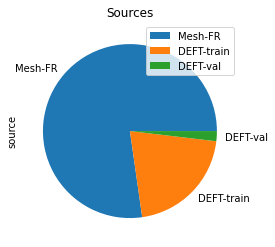

In [20]:
ax = dataset_df['source'].value_counts().plot(kind='pie',
                                    #figsize=(14,8),
                                              legend=True,
                                              title="Sources")
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (0.1+(p.get_x() * 1.005), p.get_height() * 1.01))


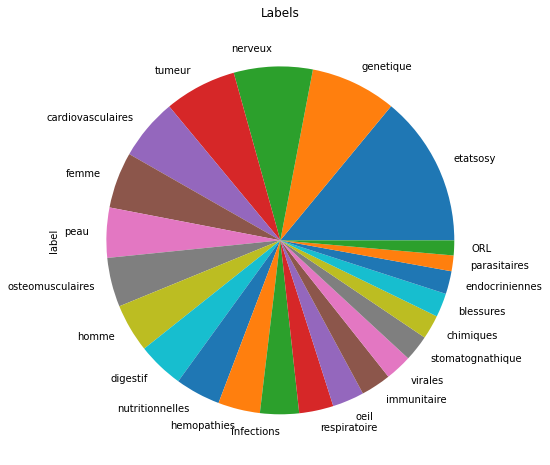

In [31]:
ax = dataset_df['label'].value_counts().plot(kind='pie',
                                             figsize=(14,8),
                                             title="Labels")
